# Skript zum Laden von Bitcoin-Tweets von Kaggle und VADER Sentiment Analyzer

In [1]:
#https://docs.python.org/3/library/math.html
import math

#https://numpy.org/doc/stable/reference/
import numpy as np

#https://pandas.pydata.org/docs/reference/index.html
import pandas as pd

#https://seaborn.pydata.org/api.html
import seaborn as sns

#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot
import matplotlib.pyplot as plt

#https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use("fivethirtyeight") #große Schriften und hoher Kontrast für eine bessere Lesbarkeit

#https://polyglot.readthedocs.io/en/latest/Detection.html
import polyglot

#https://www.nltk.org/api/nltk.html
import nltk

#https://github.com/jmcarpenter2/swifter/blob/master/docs/documentation.md
import swifter

#https://polyglot.readthedocs.io/en/latest/Detection.html
from polyglot.detect import Detector

#https://www.nltk.org/api/nltk.sentiment.sentiment_analyzer.html
from nltk.sentiment import SentimentIntensityAnalyzer

import regex as rx

import sys

#https://docs.dask.org/en/stable/install.html
import dask.dataframe as dd

import timeit

#https://docs.python.org/3/library/datetime.html
import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
nltk.set_proxy('http://sia-lb.telekom.de:8080')

## Prerequisites

* Install __polyglot__:
    pip install polyglot. For a workaround on windows see: https://stackoverflow.com/a/48056309/20027527

In [ ]:
import sys
!{sys.executable} -m pip install swifter==1.3.4
!{sys.executable} -m pip install seaborn==0.12.0
!{sys.executable} -m pip install pandas==1.0.5
!{sys.executable} -m pip install numpy==1.18.5
!{sys.executable} -m pip install matplotlib==3.2.2
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install re==2.2.1

# 1. Laden des Twitter-Datensatzes

In [2]:
#Laden der Bitcoin Tweets
#df=pd.read_csv("https://www.kaggle.com/datasets/alaix14/bitcoin-tweets-20160101-to-20190329/download/msVFdUK46gOHXNQ36xtD%2Fversions%2FhHfS5erInthb7BUV9mhn%2Ffiles%2Ftweets.csv?datasetVersionNumber=2",sep=';',usecols=["timestamp","replies","likes","retweets", "text"],parse_dates=["timestamp"])
df=pd.read_csv('tweets.csv',sep=';',usecols=["timestamp","replies","likes","retweets", "text"], parse_dates=["timestamp"])
df = df.convert_dtypes()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(df.shape)

(20165013, 5)


# 2. Datenüberprüfung und -transformation

In [4]:
print("Es gibt Daten im Zeitraum von ", df["timestamp"].min(), " bis ", df["timestamp"].max())

Es gibt Daten im Zeitraum von  2007-04-19 07:14:38+00:00  bis  2019-11-23 15:45:57+00:00


In [5]:
print('Der Datensatz hat {} Zeilen und {} Spalten'.format(df.shape[0], df.shape[1]))

Der Datensatz hat 20165013 Zeilen und 5 Spalten


In [6]:
print('Im Einzelnen handelt es sich um folgende Spalten:')
for column in df.columns:
    print(column)

Im Einzelnen handelt es sich um folgende Spalten:
timestamp
replies
likes
retweets
text


In [7]:
#Sortieren nach Datum
df_sort = df.sort_values(by=['timestamp'], ignore_index=True).head()
df_sort.reset_index(drop=True, inplace=True)

In [8]:
#Auszug der ersten 10 Zeilen des Datensatzes
df_sort.head(10)

,timestamp,replies,likes,retweets,text
0,2007-04-19 07:14:38+00:00,0,0,2,is happily mugging at BTC where she will hook ...
1,2009-01-11 03:33:52+00:00,790,14470,5542,Running bitcoin
2,2009-01-21 17:29:40+00:00,55,1544,392,Looking at ways to add more anonymity to bitcoin
3,2009-01-27 20:14:10+00:00,44,1042,277,Thinking about how to reduce CO2 emissions fro...
4,2009-01-29 13:37:53+00:00,0,28,16,From: Satoshi Nakamoto - 2009-01-11 22:32 Bitc...


In [9]:
#Auszug der letzten 10 Zeilen des Datensatzes
df.sort_values(by=['timestamp'], ignore_index=True, ascending=False).head()

,timestamp,replies,likes,retweets,text
0,2019-11-23 15:45:57+00:00,0,0,0,@btc @btc Do you know that BTC Baskets isn't...
1,2019-11-23 15:45:56+00:00,0,0,0,Register now for the early access of the Codug...
2,2019-11-23 15:45:55+00:00,0,0,0,Bitcoin Suisse Certificates :) https://t.co/nd...
3,2019-11-23 15:45:55+00:00,0,0,0,Daily profit for HODLING BTC since 2013 Data t...
4,2019-11-23 15:45:53+00:00,0,0,0,The Worlds First Millennium Firm https://t.co/...


In [10]:
#Ausgabe der einzelnen Spalten und der Datentypen
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165013 entries, 0 to 20165012
Data columns (total 5 columns):
 #   Column     Dtype              
---  ------     -----              
 0   timestamp  datetime64[ns, UTC]
 1   replies    Int64              
 2   likes      Int64              
 3   retweets   Int64              
 4   text       string             
dtypes: Int64(3), datetime64[ns, UTC](1), string(1)
memory usage: 826.9 MB


In [11]:
#Ausgabe einiger Statistiken des Datensatzes
df.describe()

,replies,likes,retweets
count,1.881052e+07,1.881052e+07,1.881052e+07
mean,2.837522e-01,2.410102e+00,9.565145e-01
std,2.196037e+01,1.390808e+02,8.153579e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00
max,7.738400e+04,2.919850e+05,1.812400e+05


In [12]:
df["month"] = df["timestamp"].dt.month
df["year"] = df["timestamp"].dt.year

pivot = pd.pivot_table(df, values='timestamp', index=['month'], columns=['year'], aggfunc='count').fillna(0)

In [13]:
pivot

year,2007.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
month,,,,,,,,,,,,
1.0,0.0,4.0,0.0,2.0,1686.0,926.0,28423.0,20236.0,17529.0,10761.0,38088.0,426621.0
2.0,0.0,1.0,0.0,1.0,1699.0,3209.0,27060.0,17766.0,129010.0,48820.0,166979.0,26129.0
3.0,0.0,0.0,1.0,1.0,2838.0,4161.0,23701.0,19299.0,19693.0,9683.0,34834.0,32546.0
4.0,1.0,0.0,1.0,8.0,2896.0,11563.0,21717.0,25245.0,17869.0,12408.0,280016.0,32478.0
5.0,0.0,0.0,0.0,38.0,2365.0,15555.0,21975.0,17393.0,15076.0,12469.0,32572.0,1761004.0
6.0,0.0,5.0,1.0,76.0,885.0,11153.0,22471.0,12453.0,14500.0,47583.0,222526.0,2562501.0
7.0,0.0,0.0,4.0,13.0,2642.0,8409.0,22363.0,13127.0,10394.0,14473.0,74162.0,2560831.0
8.0,0.0,0.0,3.0,8.0,1208.0,9343.0,21749.0,10891.0,11414.0,51227.0,1125711.0,2059752.0
9.0,0.0,1.0,0.0,7.0,1786.0,6356.0,20474.0,7621.0,8973.0,21726.0,28636.0,2047374.0


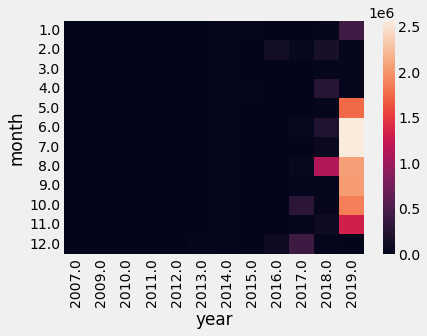

In [14]:
sns.heatmap(pivot)

In [15]:
#Begrenze Datensatz auf den Zeitraum von 2014-01-01 00:00 - 2019-11-23 00:00
d_min = datetime.datetime(2014,1,1,0,0,0,0,tzinfo=datetime.timezone.utc)
d_max = datetime.datetime(2019,11,23,0,0,0,0,tzinfo=datetime.timezone.utc)
mask = (df.timestamp >= d_min) & (df.timestamp <= d_max)
df = df.loc[mask]

In [16]:
#Prüfung ob es Zeilen mit fehlenden Daten gibt
df.isnull().any()

timestamp    False
replies      False
likes        False
retweets     False
text          True
month        False
year         False
dtype: bool

In [17]:
#Entfernen der Zeilen mit fehlenden Daten
df.dropna(how='any',inplace=True)

In [18]:
#Prüfe erneut ob es Zeilen mit fehlenden Daten gibt
df.isnull().any()

timestamp    False
replies      False
likes        False
retweets     False
text         False
month        False
year         False
dtype: bool

In [19]:
df.rename(columns={"timestamp": "date"},inplace=True)

In [20]:
#Umwandlung der Datentypen
df['date'] = pd.to_datetime(df['date'])

# 3. Vader Sentiment

In [21]:
#Download des Vader Lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\A783703\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
#Instanziere Vader Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

In [23]:
def get_sentiment(score: float) -> str:
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else: 
        return "neutral"

In [24]:
def get_compound(text: str) -> float:
    polarity = sia.polarity_scores(text)
    compound = polarity["compound"] if polarity else 0.0
    return compound

In [25]:
def get_lang(text: str) -> object:
    det = Detector(text, quiet=True)
    lang = "en" if (det.reliable & (det.language.locale.getName() == "en")) else None
    return lang

In [26]:
def clean_text(text) -> str:
    return rx.sub(r"[\p{Cc}\p{Cs}]+","",text)

In [27]:
def get_polarity(text):
    return sia.polarity_scores(text)["compound"]

In [28]:
#Bereinigen der Texte
df["text"] = df.swifter.apply(lambda x: rx.sub(r"[\p{Cc}\p{Cs}]+","",x["text"]), axis = 1)

In [29]:
#Erkennung der Sprache der Tweets. Nur englische Texte werden erfasst (Attribut lang='en').
#Alle anderen Texte bekommen ein leeres Attribut 'lang'.
df["lang"] = df.swifter.apply(lambda x: get_lang(x["text"]), axis = 1)

In [56]:
df

,index,date,replies,likes,retweets,text,month,year,lang
0,0,2019-03-12 23:23:19+00:00,1,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,3,2019,en
1,1,2019-03-21 19:21:29+00:00,0,13,13,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,3,2019,en
2,2,2019-03-09 23:10:56+00:00,0,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,3,2019,en
3,3,2019-03-12 23:09:37+00:00,1,13,9,#Bitcoin #crypto #AirdropNew Airdrop #p2pb2b 📢...,3,2019,en
4,4,2018-12-29 04:39:39+00:00,9,61,16,The first lab made diamond happened in 1955 &a...,12,2018,en
...,...,...,...,...,...,...,...,...,...
2171865,2171865,2018-10-06 11:28:49+00:00,3,10,4,I thought I should share this correctional wav...,10,2018,en
2171866,2171866,2017-11-29 05:19:33+00:00,0,6,1,"$BTCUSD #Bitcoin hits 10,0000 today,has made a...",11,2017,en
2171867,2171867,2019-02-04 02:12:55+00:00,0,3,1,#Bitcoin #blockchain #cryptocurrency https://...,2,2019,en
2171868,2171868,2018-09-15 16:10:01+00:00,2,8,1,"Welcome to Bitcoin, newcomers! Here's your FAQ...",9,2018,en


In [31]:
#Gibt es leere Zeilen?
df.isnull().any()

date        False
replies     False
likes       False
retweets    False
text        False
month       False
year        False
lang         True
dtype: bool

In [32]:
#Entfernen der Zeilen mit fehlenden Daten
df.dropna(how='any',inplace=True)

In [33]:
print(df["date"].min(), df["date"].max())

2014-01-01 00:00:11+00:00 2019-04-30 23:56:12+00:00


In [48]:
df.reset_index(drop=True,inplace=True)
df = df.convert_dtypes()

In [58]:
#Ermittle Vader Sentiment Compound Score der Tweets
df["sentiment"] = df.swifter.apply(lambda x: sia.polarity_scores(x['text'])["compound"], axis = 1)

In [59]:
df

,index,date,replies,likes,retweets,text,month,year,lang,sentiment
0,0,2019-03-12 23:23:19+00:00,1,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,3,2019,en,0.2263
1,1,2019-03-21 19:21:29+00:00,0,13,13,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,3,2019,en,0.9385
2,2,2019-03-09 23:10:56+00:00,0,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,3,2019,en,0.0000
3,3,2019-03-12 23:09:37+00:00,1,13,9,#Bitcoin #crypto #AirdropNew Airdrop #p2pb2b 📢...,3,2019,en,0.5859
4,4,2018-12-29 04:39:39+00:00,9,61,16,The first lab made diamond happened in 1955 &a...,12,2018,en,0.7678
...,...,...,...,...,...,...,...,...,...,...
2171865,2171865,2018-10-06 11:28:49+00:00,3,10,4,I thought I should share this correctional wav...,10,2018,en,0.5719
2171866,2171866,2017-11-29 05:19:33+00:00,0,6,1,"$BTCUSD #Bitcoin hits 10,0000 today,has made a...",11,2017,en,0.5574
2171867,2171867,2019-02-04 02:12:55+00:00,0,3,1,#Bitcoin #blockchain #cryptocurrency https://...,2,2019,en,0.0000
2171868,2171868,2018-09-15 16:10:01+00:00,2,8,1,"Welcome to Bitcoin, newcomers! Here's your FAQ...",9,2018,en,0.6430


In [60]:
#positive sentiment: compound score >= 0.05
#neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
#negative sentiment: compound score <= -0.05

In [61]:
#Labeln des Datensatzes: positiv/neutral/negative
df["label"] = df.swifter.apply(lambda x: get_sentiment(x["sentiment"]), axis = 1)

In [62]:
#Exportiere Dataframe nach CSV
df.to_csv (r'twitter-sentiments.csv', index = False, header=True, columns = ["date","sentiment","likes","label"])

# 4. Plots

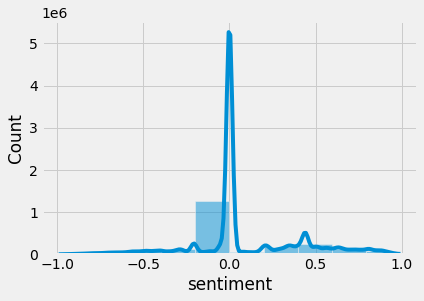

In [63]:
sns.histplot(data=df, x="sentiment", bins = 10, kde=True)

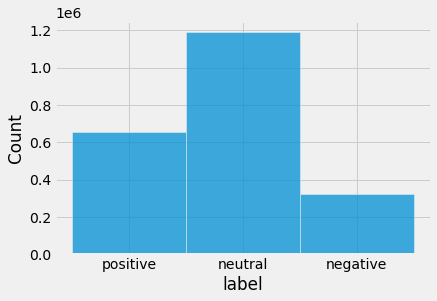

In [64]:
sns.histplot(data=df, x="label")

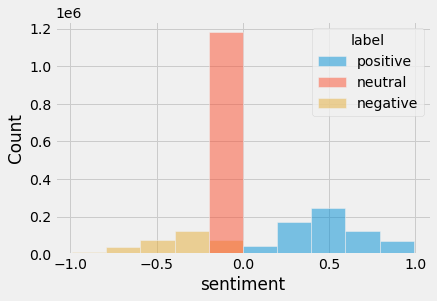

In [65]:
sns.histplot(data=df, x="sentiment", bins=10, hue="label")